In [133]:
import pandas as pd
import numpy as np

import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read Data

In [2]:
data = pd.read_csv("data/interim/data.csv", index_col=0)
train_data = pd.read_csv("data/interim/train_data.csv", index_col=0)
val_data = pd.read_csv("data/interim/test_data.csv", index_col=0)
user_data = pd.read_csv("data/interim/users.csv", index_col=0)
movie_data = pd.read_csv("data/interim/movies.csv", index_col=0)

# Prepare Data

In [122]:
from src.data.make_dataset import Vocabulary, one_hot, preprocess, RecDataset, _preprocess

In [52]:
vocab = Vocabulary("recSystem")

In [53]:
vocab.addColumn(user_data, 'occupation')
vocab.addColumn(user_data, 'gender')

# Define models

In [121]:
from src.models.model import RecommendationSys

# Train model

In [9]:
from src.models.train import train

In [76]:
train_dataset = RecDataset(train_data, vocab, device=device)
val_dataset = RecDataset(val_data, vocab, device=device)

In [77]:
epochs = 20
batch_size = 64
input_dim = len(train_dataset.data.columns) - 1
hidden_dim = 256
output_dim = 1
vocab_size = vocab.n_words
embed_size = 128
start_epoch = 1
size_user = len(user_data) + 1
size_movie = len(movie_data) + 1
lr = 1e-3
model_path = "recSys.pt"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [82]:
model = RecommendationSys(vocab, input_dim, hidden_dim, output_dim, size_user, size_movie, embed_size).to(device)

if start_epoch != 1: # Continue the existing training
    model = torch.load(model_path)

print(sum(p.numel() for p in model.parameters())/1e3, 'k parameters', sep='')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.4)

loss_train, loss_val = train(
    model, 
    train_dataloader, 
    val_dataloader, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler,
    start_epoch=start_epoch,
    epochs=epochs, 
    lr=lr, 
    model_path=model_path
)

446.593k parameters


Epoch 20: val: 100%|██████████| 313/313 [00:05<00:00, 58.80it/s, loss=0.936]


# Plot loss

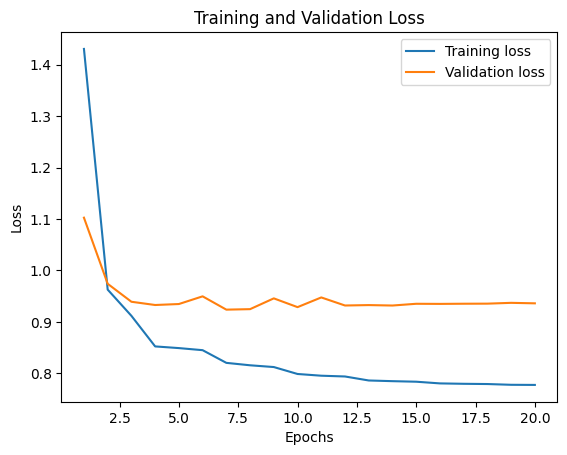

In [88]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), loss_train, label='Training loss')
plt.plot(range(1, epochs + 1), loss_val, label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

# Let's evaluate model

In [120]:
from benchmark.evaluate import evaluate

In [124]:
from tqdm import tqdm

def evaluate(model, data, user_data, movie_data, device=torch.device("cpu")):
    mseLoss = 0.0
    for _row in tqdm(data.iterrows()):
        row = _row[1]
        row = preprocess(row, user_data, movie_data, model.vocab)
        row = one_hot(row.loc[0], model.vocab)
        model_input, target = _preprocess(row.loc[0], device=device)
        model_input, target = model_input.reshape(1, -1), target
        res = model(model_input)
        mseLoss += (res.item() - target.item())**2
    
    mseLoss /= len(data)
    return mseLoss

In [125]:
evaluate(best_model, data, user_data, movie_data, device=device)

100000it [05:18, 313.76it/s]


0.8289415148454666

# Let's check on example the performance of model

In [160]:
import random
    

def combine(movie_id, user_id, movie_data, user_data):
    columns = []

    user_row = user_data.loc[user_id - 1] # index start 0
    movie_row = movie_data.loc[movie_id - 1]
    skip_mov = ["movie title", "release date", "video release date", "IMDb URL", "zip_code"]

    assert user_row['user_id'] == user_id, "user id must be the same, but found"
    assert movie_row['movie id'] == movie_id, "movie id must be the same"

    src_row = []
    for col in user_row.index.tolist():
        if col in skip_mov:
            continue
        columns.append(col)
        src_row.append(user_row[col])

    for col in movie_row.index.tolist():
        if col in skip_mov:
            continue
        columns.append(col)
        src_row.append(movie_row[col])
    
    res = pd.DataFrame([src_row], columns=columns)
    return res

def predict(model, data, ids, movie_data, user_data, top_k=5):
    model.eval()
    n_movie = len(movie_data)
    n_user = len(user_data)
    watched = []
    not_watched = []
    res_not_watched = []
    res_watched = []
    for i in range(len(data)):
        if data['user_id'][i] == ids:
            watched.append(data['item_id'][i])
            res_watched.append((data['rating'][i] * 1.0, movie_data['movie title'][watched[-1] - 1]))
    
    watched.sort()
    j = 0
    for i in range(1, n_movie + 1):
        while j < len(watched) and watched[j] < i:
            j += 1
        
        if j < len(watched) and watched[j] == i:
            continue
        not_watched.append(i)
        
    for mov in not_watched:
        row = combine(mov, ids + 1, movie_data, user_data)
        row = one_hot(row.loc[0], model.vocab)
        row['rating'] = -1
        model_input, target = _preprocess(row.loc[0], device=device)
        model_input, target = model_input.reshape(1, -1), target
        res = model(model_input)
        res_not_watched.append((res.item(), movie_data['movie title'][mov - 1]))
    
    res_watched.sort(reverse=True)
    res_not_watched.sort(reverse=True)
    
    print(f"Rated by user {ids}")
    for i in range(top_k):
        print("name: " + res_watched[i][1], "rating:", res_watched[i][0]) 
    print(f"Predicted for user {ids}")
    for i in range(top_k):
        print("name: " + res_not_watched[i][1], "rating:", res_not_watched[i][0]) 

    
def rand_predict(model, data, movie_data, user_data, n=1):
    Len = len(data)
    for _ in range(n):
        i = random.randint(0, len(user_data) - 1)
        row = data.loc[i]
        predict(model, data, i, movie_data, user_data)

In [163]:
best_model = torch.load(model_path)
rand_predict(model, data, movie_data, user_data)

Rated by user 265
name: Toy Story (1995) rating: 5.0
name: Time to Kill, A (1996) rating: 5.0
name: Saint, The (1997) rating: 5.0
name: Rock, The (1996) rating: 5.0
name: Ransom (1996) rating: 5.0
Predicted for user 265
name: Pather Panchali (1955) rating: 4.568941593170166
name: Eat Drink Man Woman (1994) rating: 4.4969072341918945
name: Saint of Fort Washington, The (1993) rating: 4.367392063140869
name: Wrong Trousers, The (1993) rating: 4.349699974060059
name: Spanish Prisoner, The (1997) rating: 4.346738338470459
